In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import tensorflow as tf
from sklearn.utils import shuffle

In [ ]:
M = sio.loadmat("/content/drive/MyDrive/MAT4373/mnist_all.mat")
M.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])

Concatenate the training data and insert 1 for the  bias

In [ ]:
training_data = np.concatenate([M['train0'], M['train1'], M['train2'], M['train3'], M['train4'], M['train5'], M['train6'], M['train7'], M['train8'], M['train9']], axis = 0)
training_data_bias_added = np.insert(training_data,0,1,axis=1)

In [ ]:
training_data.shape

(60000, 784)

Create the training labels

In [ ]:
training_size = [M['train0'].shape[0], M['train1'].shape[0], M['train2'].shape[0], M['train3'].shape[0], M['train4'].shape[0], M['train5'].shape[0], M['train6'].shape[0], M['train7'].shape[0], M['train8'].shape[0], M['train9'].shape[0]]
training_target = []
for index, value in enumerate(training_size):
    for i in range(value):
        training_target.append(index)

Concatenate the testing data and insert 1 for bias

In [ ]:
testing_data = np.concatenate([M['test0'], M['test1'], M['test2'], M['test3'], M['test4'], M['test5'], M['test6'], M['test7'], M['test8'], M['test9']], axis = 0)
testing_data_bias_added = np.insert(testing_data,0,1,axis=1)

Create the testing labels

In [ ]:
testing_size = [M['test0'].shape[0], M['test1'].shape[0], M['test2'].shape[0], M['test3'].shape[0], M['test4'].shape[0], M['test5'].shape[0], M['test6'].shape[0], M['test7'].shape[0], M['test8'].shape[0], M['test9'].shape[0]]
testing_target = []
for index, value in enumerate(testing_size):
    for i in range(value):
        testing_target.append(index)

In [ ]:
training_target = np.array(training_target)
testing_target = np.array(testing_target)

Part 1 : Include 10 images of each digit



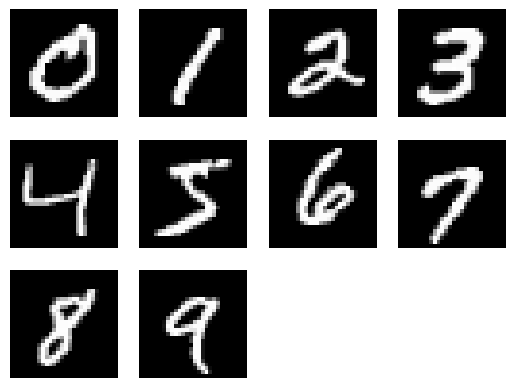

In [ ]:
index = [1, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051]
for i,image_index in enumerate(index):
  plt.subplot(3,4, i+1)
  plt.imshow(np.reshape(training_data[image_index], (28,28)), cmap='gray')
  plt.axis('off')

Shuffle the training data so that the batches are representative of the whole training dataset

In [ ]:
training_data_bias_added, training_target = shuffle(
    training_data_bias_added, training_target, random_state=10)
training_data = shuffle(training_data, random_state=10 )

In [ ]:
testing_data_bias_added, testing_target = shuffle(
    testing_data_bias_added, testing_target, random_state=20)
testing_data = shuffle(testing_data, random_state=20 )

Part 2

In [ ]:
import numpy as np 
import math

np.random.seed(0)

class Layer_Dense:
    def __init__(self, n_inputs=784, n_neurons=10):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        # set bias to 0
        self.weights = np.insert(self.weights, 0,0, axis=0)

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights)

In [ ]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

In [ ]:
# calculate log loss
def calculate_loss(y_pred, y_true):
  # clip values to prevent infinity problems
  y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
  correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
  # Calculate the negative log value to find the loss for each element
  negative_log_likelihoods = -np.log(correct_confidences)
  # Calculate the average loss of the batch using the mean
  return np.mean(negative_log_likelihoods)



In [ ]:
# one-hot encode the target variable
def encode(target, size=10):
    encoded = np.zeros(shape=(target.shape[0],size))
    for i in range(target.shape[0]):
        encoded[i][target[i]] = 1
    return encoded

Part 3: Implement a function that computes the gradient of the negative log loss function with respect to the weights of the network 

In [ ]:
  
def calculate_derivatives(probabilities,input,target):
  batch_size = input.shape[0]
  input_size = 785
  output_size = 10
  
  derivatives = np.zeros(shape=(batch_size,input_size,output_size))
  diff = probabilities - target
  for i in range(batch_size):
    # current_diff contains 10 outputs for each 10 neurons
    current_diff = diff[i]
    # current_input contains 785 entries
    current_input = input[i]
    for j in range(input_size):
      input_entry = current_input[j]
      derivative = input_entry * current_diff
      derivatives[i][j] = derivative

  avg_derivative = np.mean(derivatives,axis=0)
  weight_updates = np.count_nonzero(avg_derivative)
  return avg_derivative, weight_updates
    
def adjust_weights(derivative, previous_weights, alpha = 0.01):
    new_weights = previous_weights - (alpha * derivative)
    return new_weights

Part 4

In [ ]:
def add_diff(training_data, h=0.001):
  data = np.empty((training_data.shape[0],training_data.shape[1]))
  training_data = training_data.astype('float32') 
  for index ,element in enumerate(training_data):
    for i in range(len(element)):
      if element[i] != 0:
        element[i] = element[i]  + h
    data[index] = element
  return data

In [ ]:
def finite_diff(training_data, training_target,layer, h =0.001):
  def calculate_weight(training_data, training_target,layer):
    activation = Activation_Softmax()
    layer.forward(training_data)
    logits = layer.output
    activation.forward(logits)
    probabilities = activation.output
    derivative,_ = calculate_derivatives(
        probabilities, training_data, encode(training_target))
    new_weights = adjust_weights(derivative,layer.weights)
    return new_weights, derivative

  weights,derivative = calculate_weight(training_data, training_target, layer)
  new_weights,_ = calculate_weight(
      add_diff(training_data , 0.001), training_target, layer)
  approximation = (new_weights - weights)/ (h * -0.01) # learning rate = -0.01

  return approximation, derivative

In [247]:
layer = Layer_Dense()
approximation, derivative = finite_diff(training_data_bias_added[0:50],training_target[0:50],layer)
diff = (approximation - derivative)**2
mse = np.sum(diff)/(785*10)
print(mse)

66.68411478717768


In [251]:
np.isclose(approximation, derivative, atol=0.01)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
derivative

array([[ 0.11977397,  0.2317593 , -0.09977397, ..., -0.03841024,
         0.0529641 ,  0.03369216],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Part 5: Use mini-batch gradient descent to classify the data

In [ ]:
# train the neural network
def train(training_data, training_target, layer, activation, batch_size=50):
  
  total_loss = 0

  total_weight_updates = []
  total_loss_per_batch = []
  total_correction_classifications_per_batch = []

  for i in range(0,training_data.shape[0],batch_size):
    batch = training_data[i:i+ batch_size]
    batch_target = training_target[i: i + batch_size]
    batch_target_encoded = encode(batch_target)
    
    # forward pass
    layer.forward(batch)
    logits = layer.output
    activation.forward(logits)
    probabilities = activation.output

    # calculate the number of correct classifications in the batch
    prediction = np.argmax(probabilities, axis = 1)
    correct_classifications = np.sum(batch_target == prediction)
    total_correction_classifications_per_batch.append(correct_classifications)

    # calculate loss for current batch
    loss = calculate_loss(probabilities, batch_target_encoded)
    total_loss_per_batch.append(loss)
    total_loss += loss

    # backward pass
    derivative, weight_updates = calculate_derivatives(
        probabilities, batch, batch_target_encoded)
    total_weight_updates.append(weight_updates)
    new_weights = adjust_weights(derivative,layer.weights)
    layer.weights = new_weights
  return total_loss,total_loss_per_batch, total_weight_updates, total_correction_classifications_per_batch, layer

In [ ]:
# Use the trained network to make predictions

def test(testing_data, testing_target,layer,activation, batch_size=50):
  predictions = []
  total_correct_classifications = []

  for i in range(0,testing_data.shape[0],batch_size):
    test_batch = testing_data[i: i + batch_size]
    test_batch_target = testing_target[i: i + batch_size]

    # forward pass
    layer.forward(test_batch)
    logits = layer.output
    activation.forward(logits)
    probabilities = activation.output

    # obtain predicted values
    prediction = np.argmax(probabilities, axis=1)
    correct_classifications = np.sum(test_batch_target == prediction)
    total_correct_classifications.append(correct_classifications)
    predictions.extend(prediction.tolist())
  return predictions, total_correct_classifications
  

In [ ]:
layer = Layer_Dense()
activation = Activation_Softmax()
total_loss, total_loss_per_batch, total_weight_updates,total_correction_classifications_per_batch, trained_layer = train(training_data_bias_added, training_target, layer, activation)

In [ ]:
test_predictions, test_total_correction_classifications = test(testing_data_bias_added, testing_target,trained_layer,activation)

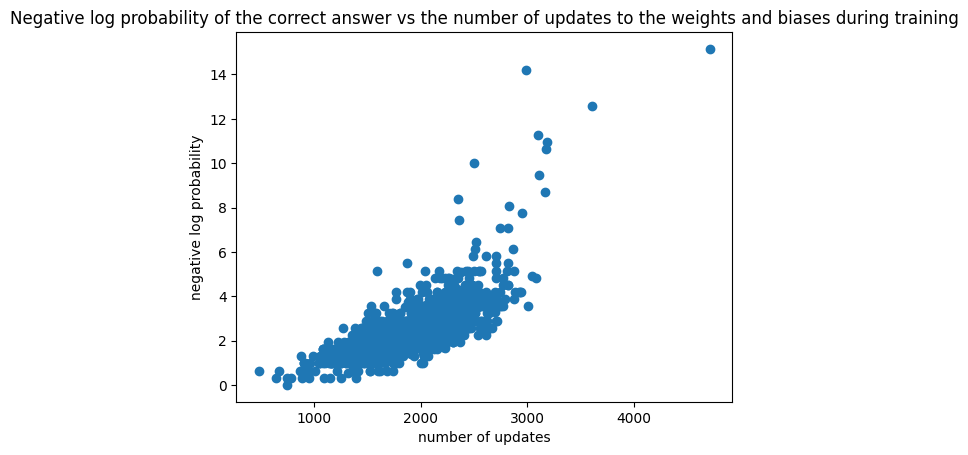

In [ ]:
plt.title("Negative log probability of the correct answer vs the number of updates to the weights and biases during training") 
plt.xlabel("number of updates") 
plt.ylabel("negative log probability") 
plt.scatter(total_weight_updates,total_loss_per_batch) 
plt.show()

In [ ]:
train_iterations = np.arange(len(total_weight_updates))

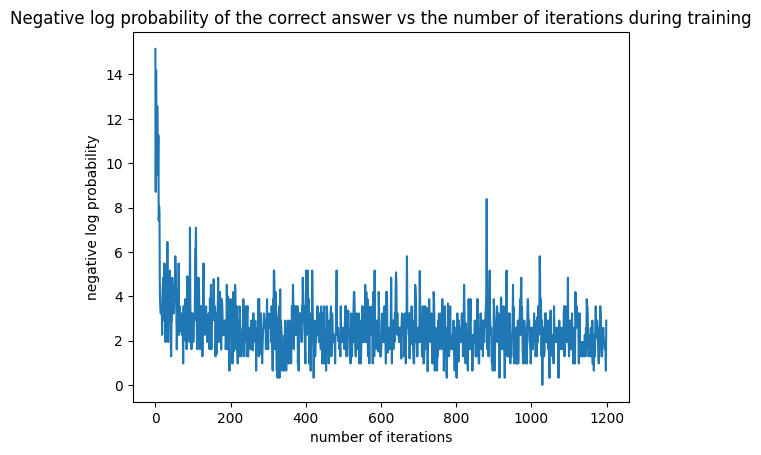

In [ ]:
plt.title("Negative log probability of the correct answer vs the number of iterations during training") 
plt.xlabel("number of iterations") 
plt.ylabel("negative log probability") 
plt.plot(train_iterations,total_loss_per_batch) 
plt.show()

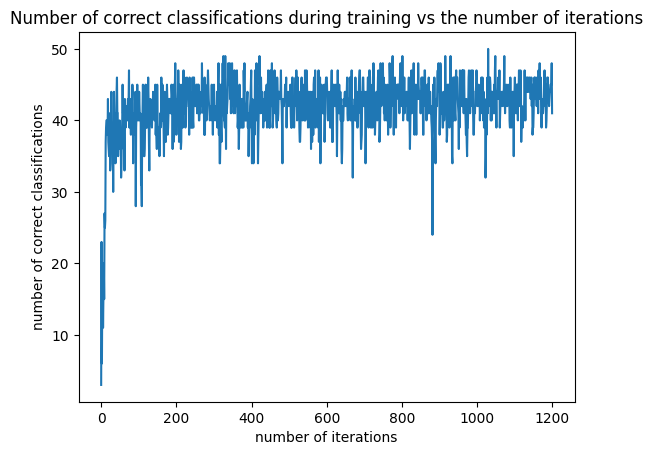

In [ ]:
plt.title("Number of correct classifications during training vs the number of iterations") 
plt.xlabel("number of iterations") 
plt.ylabel("number of correct classifications") 
plt.plot(train_iterations,total_correction_classifications_per_batch) 
plt.show()

In [ ]:
test_iterations = np.arange(len(test_total_correction_classifications))

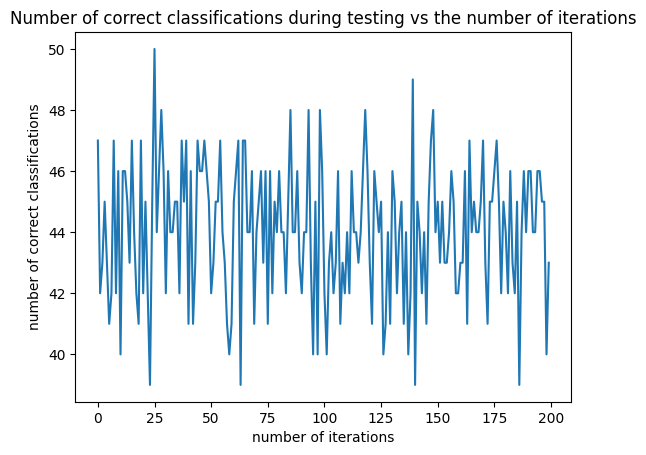

In [ ]:
plt.title("Number of correct classifications during testing vs the number of iterations") 
plt.xlabel("number of iterations") 
plt.ylabel("number of correct classifications") 
plt.plot(test_iterations,test_total_correction_classifications) 
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(testing_target, test_predictions))

[[ 942    0    4    2    0   10    5    1   16    0]
 [   0 1066    8    6    0    1    4    2   48    0]
 [   4    6  901    8    3    5    7    9   86    3]
 [   0    0   27  813    0   57    2    6  100    5]
 [   2    1    8    1  917    0   11    1   29   12]
 [   5    1    3   25    7  721    8    5  115    2]
 [  15    1   19    1    6   31  869    2   14    0]
 [   5    5   41   12   11    2    0  921   16   15]
 [   3    4    3   12    5   15    5    2  924    1]
 [   9    3    4    6  102   14    0   34   99  738]]


In [ ]:
print(classification_report(testing_target, test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.94      0.96      1135
           2       0.89      0.87      0.88      1032
           3       0.92      0.80      0.86      1010
           4       0.87      0.93      0.90       982
           5       0.84      0.81      0.82       892
           6       0.95      0.91      0.93       958
           7       0.94      0.90      0.92      1028
           8       0.64      0.95      0.76       974
           9       0.95      0.73      0.83      1009

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.90      0.88      0.88     10000



In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(testing_target, test_predictions))

0.8812


In [ ]:
total_loss

3088.115487003082

Display 20 digits that were classified correctly

In [ ]:
correct_classifications_index = np.where(np.equal(testing_target, test_predictions))[0][0:20]

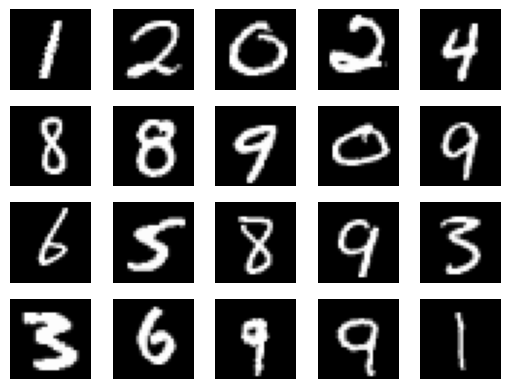

In [ ]:
for i,image in enumerate(correct_classifications_index):
  plt.subplot(4,5, i+1)
  plt.imshow(np.reshape(testing_data[image], (28,28)), cmap='gray')
  plt.axis('off')

Display 10 digits that were classified incorrectly

In [ ]:
incorrect_classifications_index = np.where(np.not_equal(testing_target, test_predictions))[0][0:10]

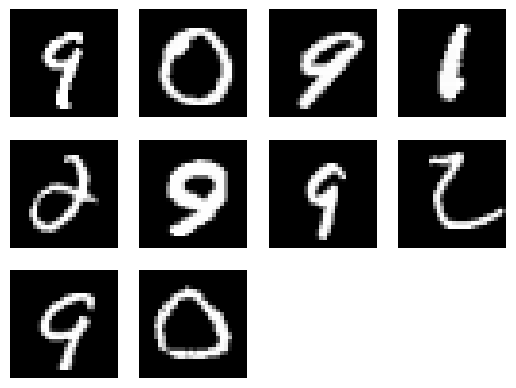

In [ ]:
for i,image in enumerate(incorrect_classifications_index):
  plt.subplot(3,4, i+1)
  plt.imshow(np.reshape(testing_data[image], (28,28)), cmap='gray')
  plt.axis('off')

Part 6:
Visualize the weights of the network

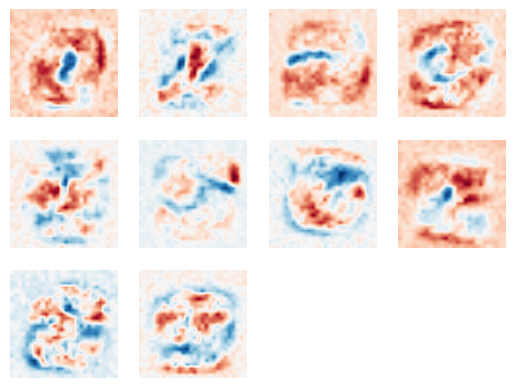

In [ ]:
weights_transposed = np.transpose(trained_layer.weights)
for i,weights in enumerate(weights_transposed):
  weights = np.delete(weights,0)
  plt.subplot(3,4, i+1)
  plt.imshow(np.reshape(weights, (28,28)), cmap=plt.cm.RdBu_r,interpolation='bilinear' )
  plt.axis('off')


Part 7 Keras

In [ ]:
training_data = training_data.astype('float32') / 255
temp = []
for data in training_data:
  data = np.reshape(data,(28,28))
  temp.append(data)
training_data = np.array(temp)

In [ ]:
testing_data = testing_data.astype('float32') / 255
temp = []
for data in testing_data:
  data = np.reshape(data,(28,28))
  temp.append(data)
testing_data = np.array(temp)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='tanh'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_info = model.fit(
    training_data,
    training_target,
    batch_size=50,
    epochs=6,
    validation_data=(testing_data, testing_target)
)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1200/1200 [==============================] - 9s 7ms/step - loss: 0.2837 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.1635 - val_sparse_categorical_accuracy: 0.9528
Epoch 2/6
1200/1200 [==============================] - 7s 5ms/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.1124 - val_sparse_categorical_accuracy: 0.9670
Epoch 3/6
1200/1200 [==============================] - 8s 6ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.0946 - val_sparse_categorical_accuracy: 0.9691
Epoch 4/6
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0749 - val_sparse_categorical_accuracy: 0.9766
Epoch 5/6
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.0681 - val_sparse_categorical_accuracy: 0.9781
Epoch 6/6
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0332 - sparse_categorical_ac

Part 8

In [ ]:
loss, acc = model.evaluate(testing_data, testing_target, batch_size=50)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

200/200 [==============================] - 1s 3ms/step - loss: 0.0638 - sparse_categorical_accuracy: 0.9811

Test accuracy: 98.1%


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


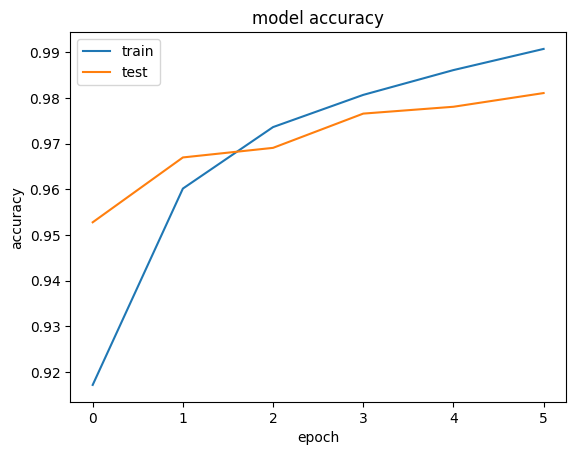

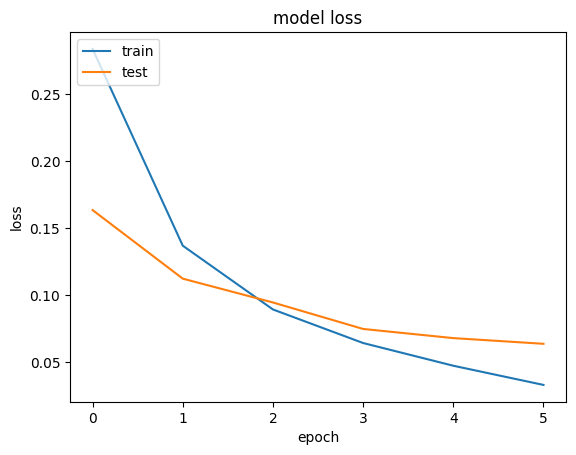

In [ ]:
print(model_info.history.keys())
# Plot the loss and accuracy curves for training and validation 
# summarize history for accuracy
plt.plot(model_info.history['sparse_categorical_accuracy'])
plt.plot(model_info.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Part 9

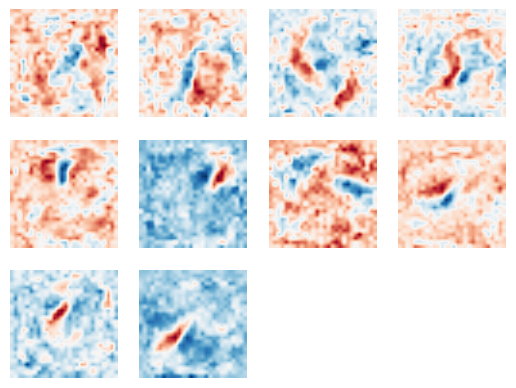

In [ ]:
hidden_weights = np.transpose(model.get_weights()[0])
output_weights = np.transpose(model.get_weights()[2])
max = []
for element in output_weights:
  max.append(np.argmax(element))

for i,index in enumerate(max):
  plt.subplot(3,4, i+1)
  plt.imshow(np.reshape(hidden_weights[index], (28,28)), cmap=plt.cm.RdBu_r,interpolation='bilinear' )
  plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

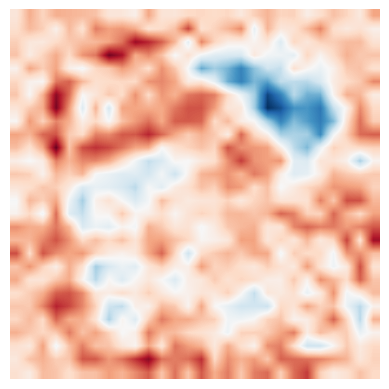

In [ ]:
weights = hidden_weights[186]
plt.imshow(np.reshape(weights, (28,28)), cmap=plt.cm.RdBu_r,interpolation='bilinear' )
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

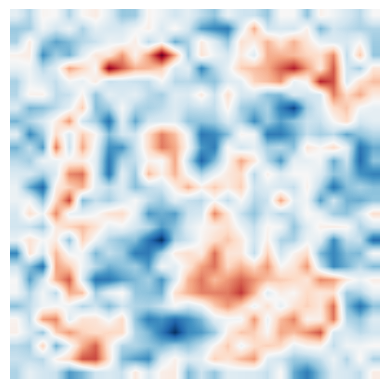

In [ ]:
weights = hidden_weights[91]
plt.imshow(np.reshape(weights, (28,28)), cmap=plt.cm.RdBu_r,interpolation='bilinear' )
plt.axis('off')